In [51]:
# https://scikit-learn.org/stable/modules/permutation_importance.html

In [52]:
!pip install -q scikit-optimize imbalanced-learn

In [53]:
# Misc
RANDOM_STATE = 42

In [54]:
import os
import json
import joblib # https://stackoverflow.com/questions/56107259/how-to-save-a-trained-model-by-scikit-learn

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from skopt import BayesSearchCV
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
  )

# Data splitting

In [55]:
!gdown --fuzzy https://drive.google.com/file/d/17qgFjTIUgxsiURgGjVC6WlEFn6Wl-OeJ/view?usp=sharing

Downloading...
From: https://drive.google.com/uc?id=17qgFjTIUgxsiURgGjVC6WlEFn6Wl-OeJ
To: /content/cleaned_bmarket.csv
100% 2.65M/2.65M [00:00<00:00, 126MB/s]


In [56]:
df = pd.read_csv("./cleaned_bmarket.csv")

In [57]:
y = df['Subscription Status']
X = df.drop('Subscription Status', axis=1)
X = pd.get_dummies(X, drop_first=True) # PLEASE rememeber to research label encoder >.<

In [58]:
print(X.shape, y.shape)

(40787, 26) (40787,)


In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

In [60]:
print(X_train.shape, y_train.shape)

(32629, 26) (32629,)


# Misc

In [63]:
class ModelWrapper:
    def __init__(self, title, model, hyperparameters, param_grid, cv, n_iterations=50):
        self.title = title
        self.model = model(**hyperparameters)
        self.param_grid = param_grid
        self.cv = cv
        self.n_iterations = n_iterations

        self.best_epoch = None
        self.best_params = None
        self.best_model = None

    def run_gridsearch(self, X, y):
        gs = GridSearchCV(
            estimator=self.model,
            param_grid=self.param_grid,
            cv=self.cv,
            scoring='f1',
            n_jobs=-1,
            verbose=2,
            return_train_score=True
        )

        gs.fit(X, y) # PLSSSS TRAINNNNNN :3

        self.best_params = gs.best_params_
        self.best_model = gs.best_estimator_
        if hasattr(gs.best_estimator_, 'n_estimators'):
            self.best_epoch = gs.best_estimator_.n_estimators
        else:
            self.best_epoch = getattr(gs.best_estimator_, 'n_iter_')

    def run_bayessearch(self, X, y):
        bs = BayesSearchCV(
            estimator=self.model,
            search_spaces=self.param_grid,
            cv=self.cv,
            scoring='f1', # Due to class imbalance
            n_jobs=-1,
            verbose=2,
            return_train_score=True,
            n_iter=self.n_iterations
        )

        bs.fit(X, y)

        self.best_params = bs.best_params_
        self.best_model = bs.best_estimator_
        if hasattr(bs.best_estimator_, 'n_estimators'):
            self.best_epoch = bs.best_estimator_.n_estimators
        else:
            self.best_epoch = getattr(bs.best_estimator_, 'n_iter_')

    def write_info_to_disk(self, X, y, folder_path):
        save_dir = os.path.join(folder_path, self.title)
        os.makedirs(save_dir, exist_ok=True)

        model_path = os.path.join(save_dir, f"{self.title}.pkl")
        joblib.dump(self.best_model, model_path)

        params_path = os.path.join(save_dir, 'parameters.json')
        with open(params_path, 'w') as f:
            json.dump(self.best_params, f, indent=4)

        y_pred = self.best_model.predict(X)

        cm = confusion_matrix(y, y_pred)

        plt.figure(figsize=(8, 6))
        ax = sns.heatmap(cm, annot=True, fmt='d')
        labels = ["False", "True"]
        plt.title(f"Confusion Matrix: {self.title}")
        ax.set_xticklabels(labels)
        ax.set_yticklabels(labels)
        ax.set_ylabel("Actual")
        ax.set_xlabel("Predicted")

        plot_path = os.path.join(save_dir, 'cmatrix.png')
        plt.savefig(plot_path)
        plt.close()

        test_error = pd.concat([measure_error(y, y_pred, 'test')], axis=1)
        test_error.to_csv(os.path.join(save_dir, 'test_error.csv'))

In [64]:
###################
# Hyperparameters #
###################

from skopt.space import Real, Categorical, Integer

# Random Forest: {
rf_params = {
    "n_jobs": 1,
    "oob_score": True,
    "warm_start": False,
    "random_state": RANDOM_STATE
}

# rf_gs_params = {
#     "max_features": ["log2"],
#     "min_samples_split": [2, 5, 10],
#     'max_samples': [0.75, None,],
#     "class_weight": ["balanced", None],
#     "max_depth": [20, None],
#     "n_estimators": [1500, 2000],
# }

rf_bayes_params = {
    "max_features": Categorical(["sqrt", "log2"]),
    "min_samples_split": Integer(2, 25),
    "max_samples": Real(0.5, 1.0),
    "class_weight": Categorical(["balanced", None]),
    "max_depth": Integer(10, 300),
    "n_estimators": Integer(200, 1000),
}
# }

In [65]:
def measure_error(y_true, y_pred, label):
    return pd.Series({
        'accuracy':accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred)},
        name=label)

# Ensemble models

### Random Forest

**Optimization Methods**


*   Grid Search
*   Adjusting decision threshold

Only boosting trees plot training and validation loss


In [66]:
from sklearn.ensemble import RandomForestClassifier

In [67]:
rf_ens = ModelWrapper(
    title = "RandomForestClassifier",
    model = RandomForestClassifier,
    hyperparameters = {**rf_params},
    param_grid = {**rf_bayes_params},
    cv = 2,
    n_iterations=10
)

In [68]:
clfs = [
    rf_ens
]

In [69]:
for model in clfs:
    model.run_bayessearch(X_train, y_train)
    model.write_info_to_disk(X_test, y_test, "/content")

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits


In [70]:
pd.read_csv("./RandomForestClassifier/test_error.csv")

,Unnamed: 0,test
0,accuracy,0.762932
1,precision,0.221613
2,recall,0.439608
3,f1,0.294675


In [71]:
from sklearn.metrics import roc_curve, roc_auc_score

y_pred_proba = rf_ens.best_model.predict_proba(X)[:, 1]
fpr, tpr, _ = roc_curve(y, y_pred_proba)
auc_score = roc_auc_score(y, y_pred_proba)

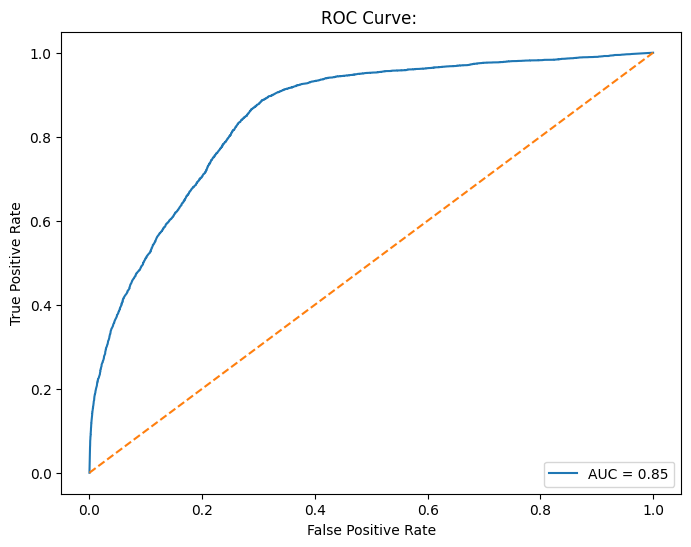

In [72]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve: ")
plt.legend(loc=4)
plt.show()